## Multi Objective Optimization example

This example demonstrates how to optimize the production of L-tyrosine in yeast by modifying reactions bounds.
The medium has limited glucose (10 mmol/gDW/h) and ozygen (12.5 mmol/gDW/h).
Two objective functions are used to search the modification space, the biomass-product coupled yield (BPCY), with flux values obtained from lMOMA phenotype predictions, and the weighed yield (WYIELD).
Solutions are limites to 10 modifications.

The first step constist on importing the required modules and setting the optimization problem.

In [1]:
from mewpy.simulation import SimulationMethod, get_simulator
from mewpy.problems import RKOProblem, ROUProblem
from mewpy.optimization.evaluation import BPCY,WYIELD
from mewpy.optimization import EA
from collections import OrderedDict

%matplotlib notebook

from reframed.io.sbml import load_cbmodel
model = load_cbmodel('models/yeast/iMM904SL_v6.xml', flavor='cobra')


BIOMASS_ID = 'R_biomass_SC5_notrace'
PRODUCT_ID = 'R_EX_tyr_L_e_'
O2 = 'R_EX_o2_e_'
GLC = 'R_EX_glc_e_'
envcond = {GLC: (-10.0,999999.0), O2: (-12.25,100000.0)}
model.set_objective({BIOMASS_ID:1})

# compute reference flux values (optional)
simulation = get_simulator(model,envcond= envcond) 
res = simulation.simulate(method='pFBA')
reference = res.fluxes


# The evaluation (objective) functions
evaluator_1 = WYIELD(BIOMASS_ID, PRODUCT_ID)
evaluator_2 = BPCY(BIOMASS_ID, PRODUCT_ID, uptake = GLC, method='lMOMA' ,reference=reference)

# The reaction up and down regulation optimization problem
problem = ROUProblem( model, 
                      fevaluation=[evaluator_1,evaluator_2], 
                      envcond = envcond,  
                      candidate_max_size = 10)

In the second step, we create an instance of the EA optimizer for the problem.
The stopping criteria is set to 10 generations (1100 evaluations).
However, the stopping criteria should contemplate more evaluations for real purpose optimization.

<IPython.core.display.Javascript object>


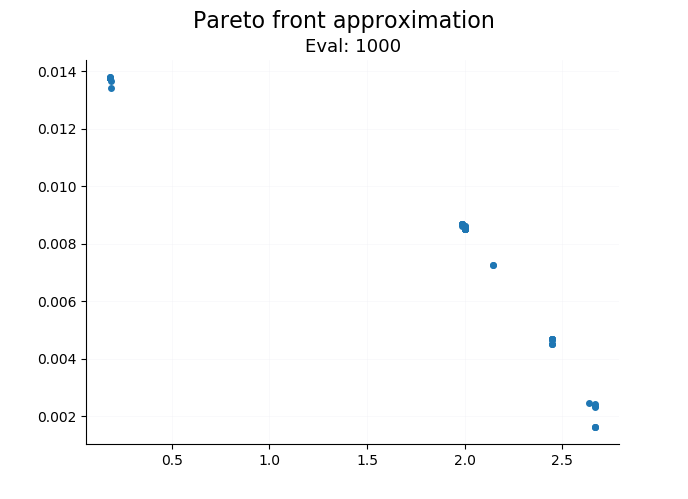

Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  0.000000  2.666341  0.009087  0.314429  0.802022|  0.000000  0.013568  0.000000  0.000207  0.001355|
    200|  0.000000  2.666341  0.009087  0.497181  0.954948|  0.000000  0.013694  0.000002  0.000516  0.002312|
    300|  0.000000  2.666341  0.916075  1.194978  1.162680|  0.000000  0.013780  0.000261  0.001971  0.004384|
    400|  0.006936  2.666341  2.443983  1.831322  1.081289|  0.000114  0.013780  0.000584  0.004029  0.005792|
    500|  0.184052  2.666341  1.999265  1.419052  1.130104|  0.000280  0.013780  0.002395  0.006651  0.006222|
    600|  0.184052  2.666341  1.999265  1.501487  1.116113|  0.000280  0.013780  0.007994  0.007071  0.005689|
    700|  0.185017  2.666341  2.443983  2.024085  0.920476|  0.000280  0.013788  0.004512  0.005699  0.004699|
    800|  0.185017  2.666341  1.999265  1.913814  0.901489|  0.000440  0.013788  0.008421  0.006889  0.004306|
 

In [3]:

ea = EA(problem, max_generations = 10,visualizer = True,mp=True)
# runs the optimization
final_pop = ea.run()

Other tasks may be performed, such as view the proposed solutions and fitness values:

In [4]:
print(final_pop[1])

[0.18651109989653752, 0.01364905753945545]
OrderedDict([('R_ILETA', (0, 0.0)), ('R_ADA', (0, 0.0)), ('R_DNMPPA', (0, 0.0)), ('R_TYRTAim', (0.30965111361210873, 10000)), ('R_FAS120', (0.0, 10000)), ('R_AGAT_SC', (0.11803059423177559, 10000)), ('R_FA180ACPtm', (0.0, 10000))])


It is also possible to plot the production envelope for L-tyrosine when the modifications are applied.

<IPython.core.display.Javascript object>


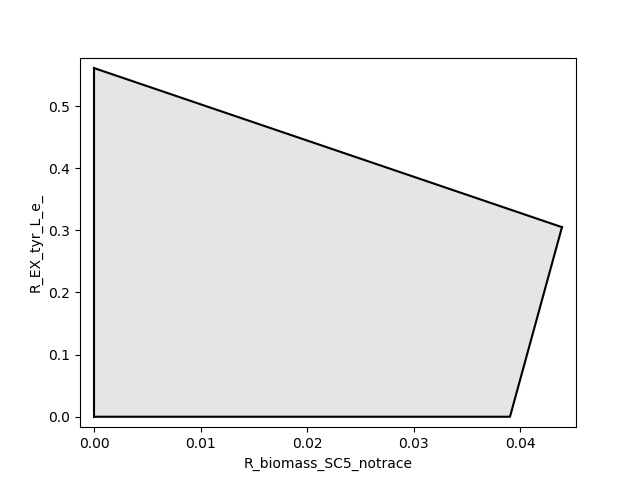

In [6]:
from mewpy.visualization.envelope import plot_flux_envelope
constraints = final_pop[1].get_constraints()
plot_flux_envelope(model,BIOMASS_ID,PRODUCT_ID,constraints=constraints)